<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Time Series Analysis</h1>
        <h1>Decomposition</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import watermark

%matplotlib inline
%load_ext watermark

List out the versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: f9d4cec09ba53403d784a160040012e6b7630793

json      : 2.0.9
watermark : 2.1.0
matplotlib: 3.3.2
pandas    : 1.1.3
numpy     : 1.19.2



Set the default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Load airline passenger data

In this notebook we are going to take a deep look at the airline dataset discussed earlier. We start by loading it

In [4]:
airline = pd.read_csv('data/international-airline-passengers.csv', sep=';')
airline['Month'] = pd.to_datetime(airline['Month']+'-01')
airline.set_index('Month', inplace=True)

And making a quick plot to make sure everything is ok.

Text(0, 0.5, 'Passengers')

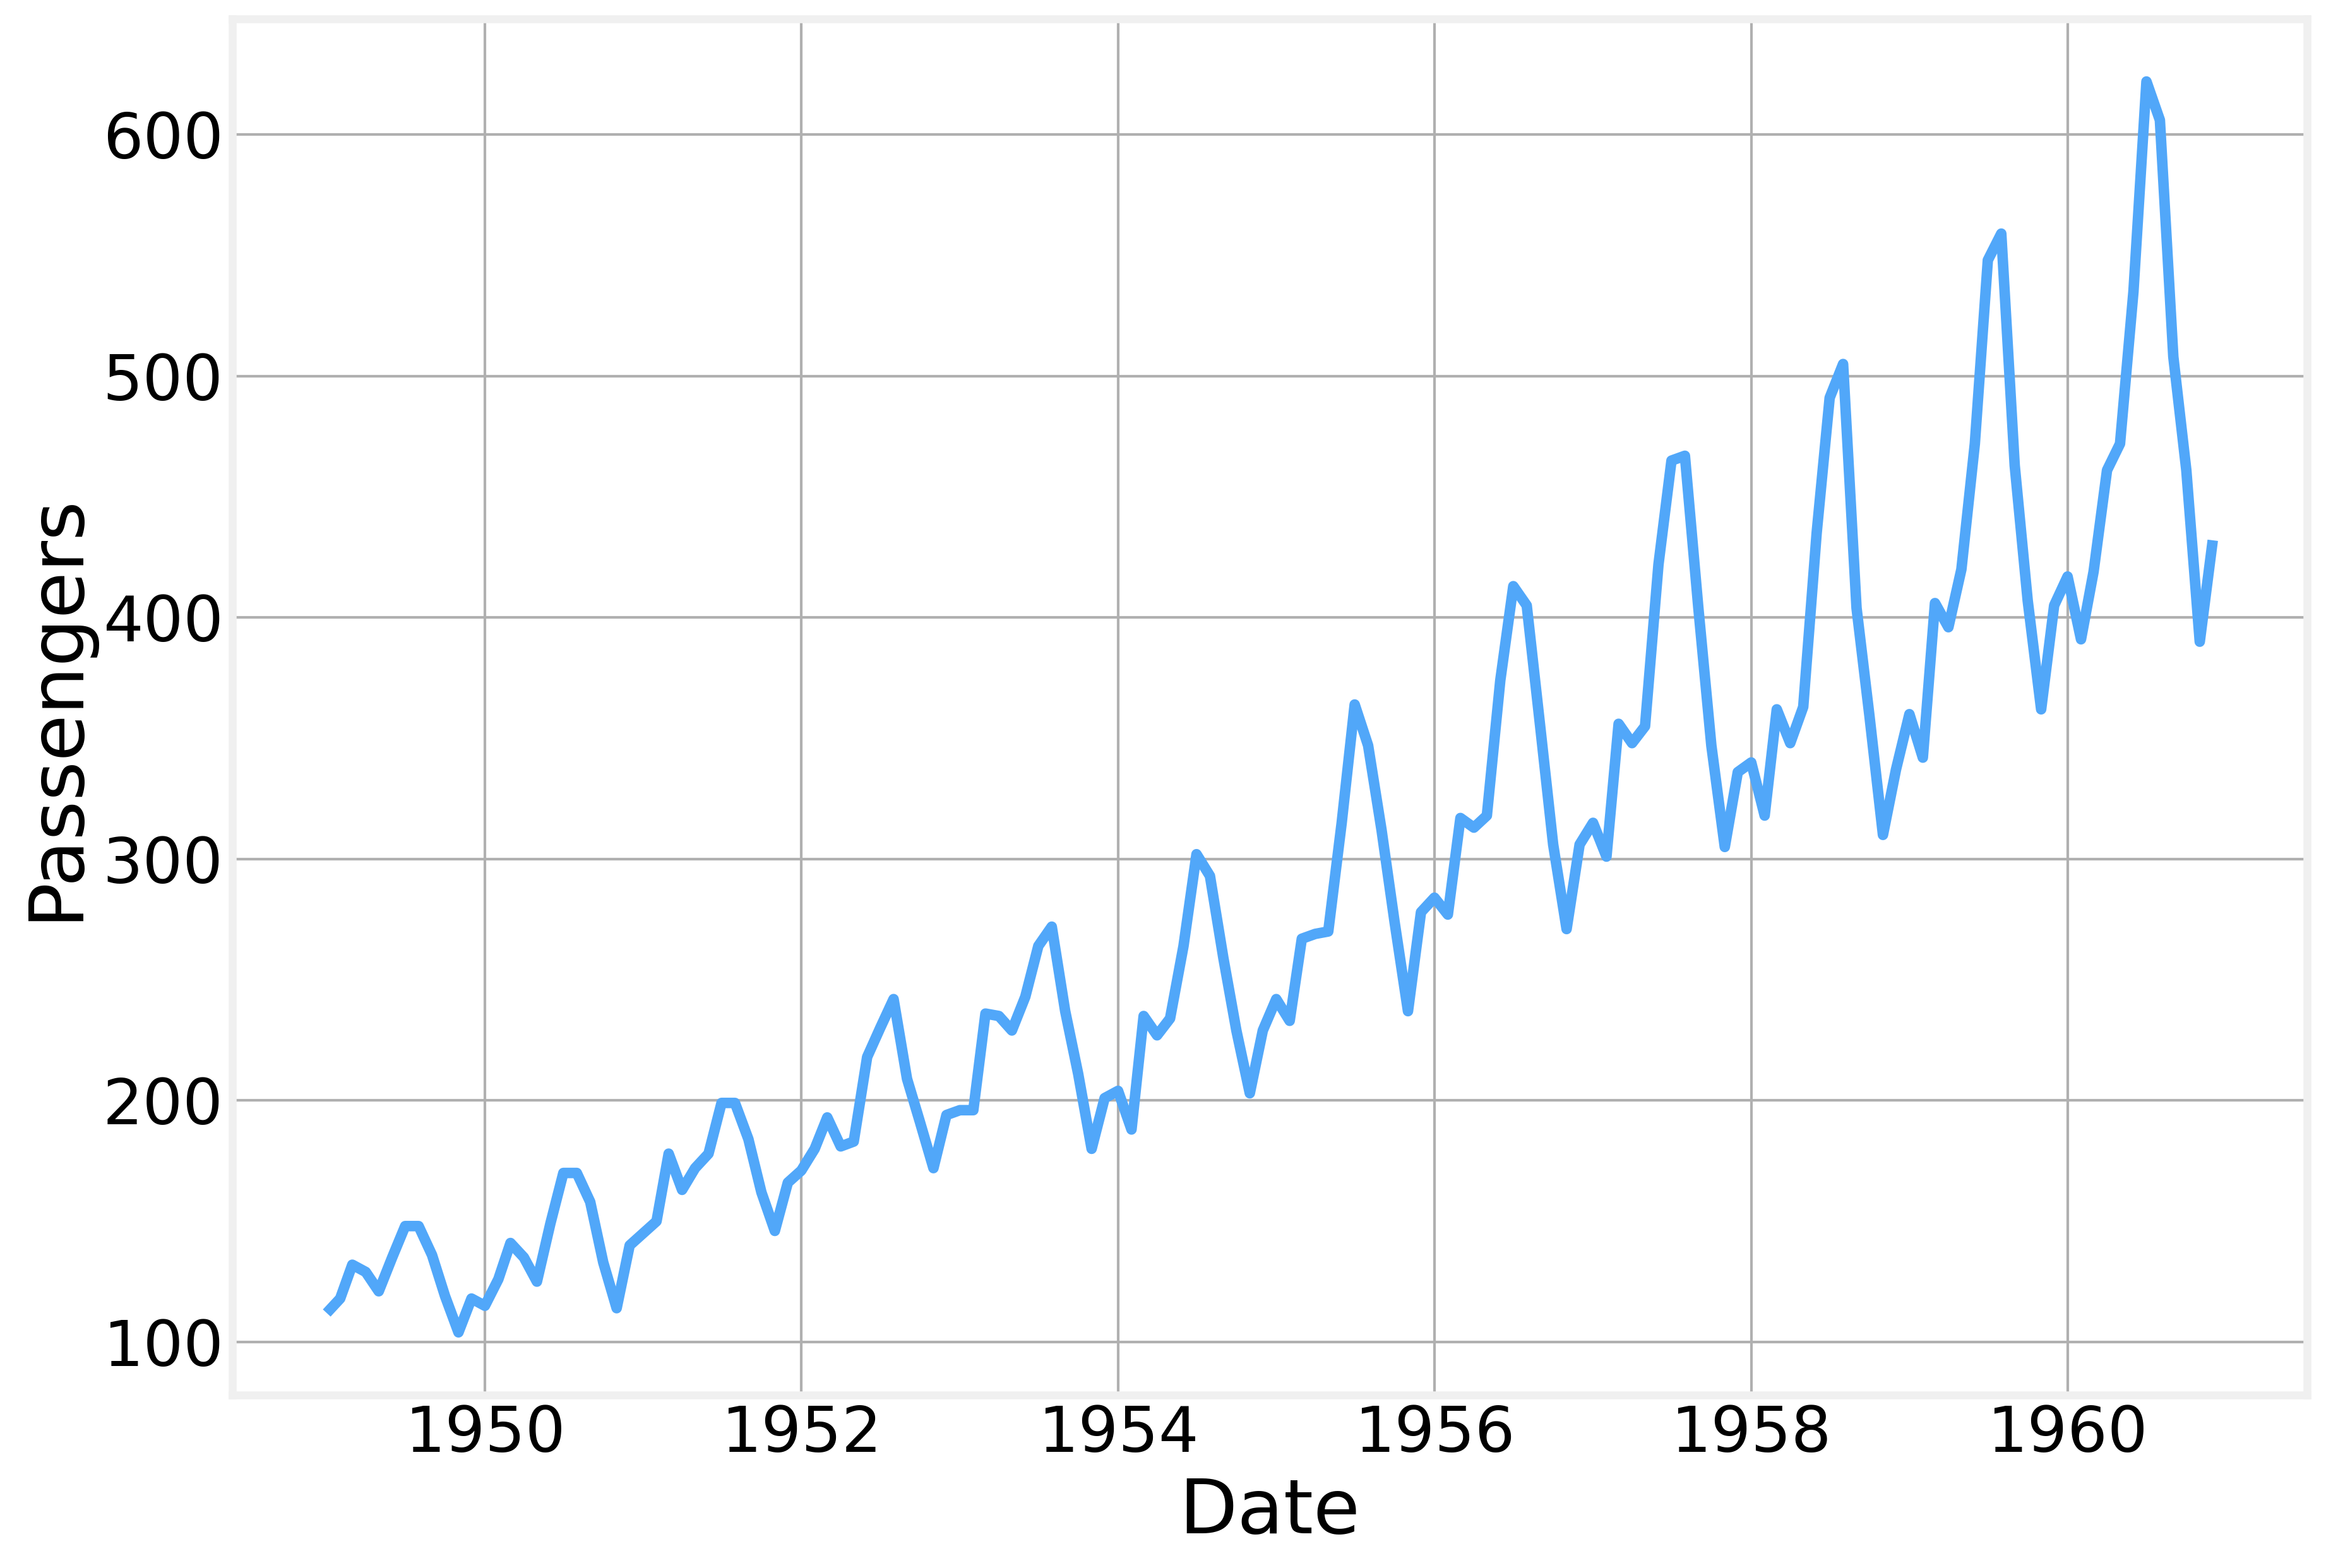

In [5]:
fig, ax = plt.subplots(1, 1)
ax.plot(airline.index, airline['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')

## Trend

We identify the trending behavior by taking a running average. 

In [6]:
def running_average(x, order):
    current = x[:order].sum()
    running = []
    
    for i in range(order, x.shape[0]):
        current += x[i]
        current -= x[i-order]
        running.append(current/order)
    
    return np.array(running)

The running_average function is self-explanatory. It simply runs over the entire dataset one step at a time and calculates the average value within each window. Now we add the trend line to the previous plot

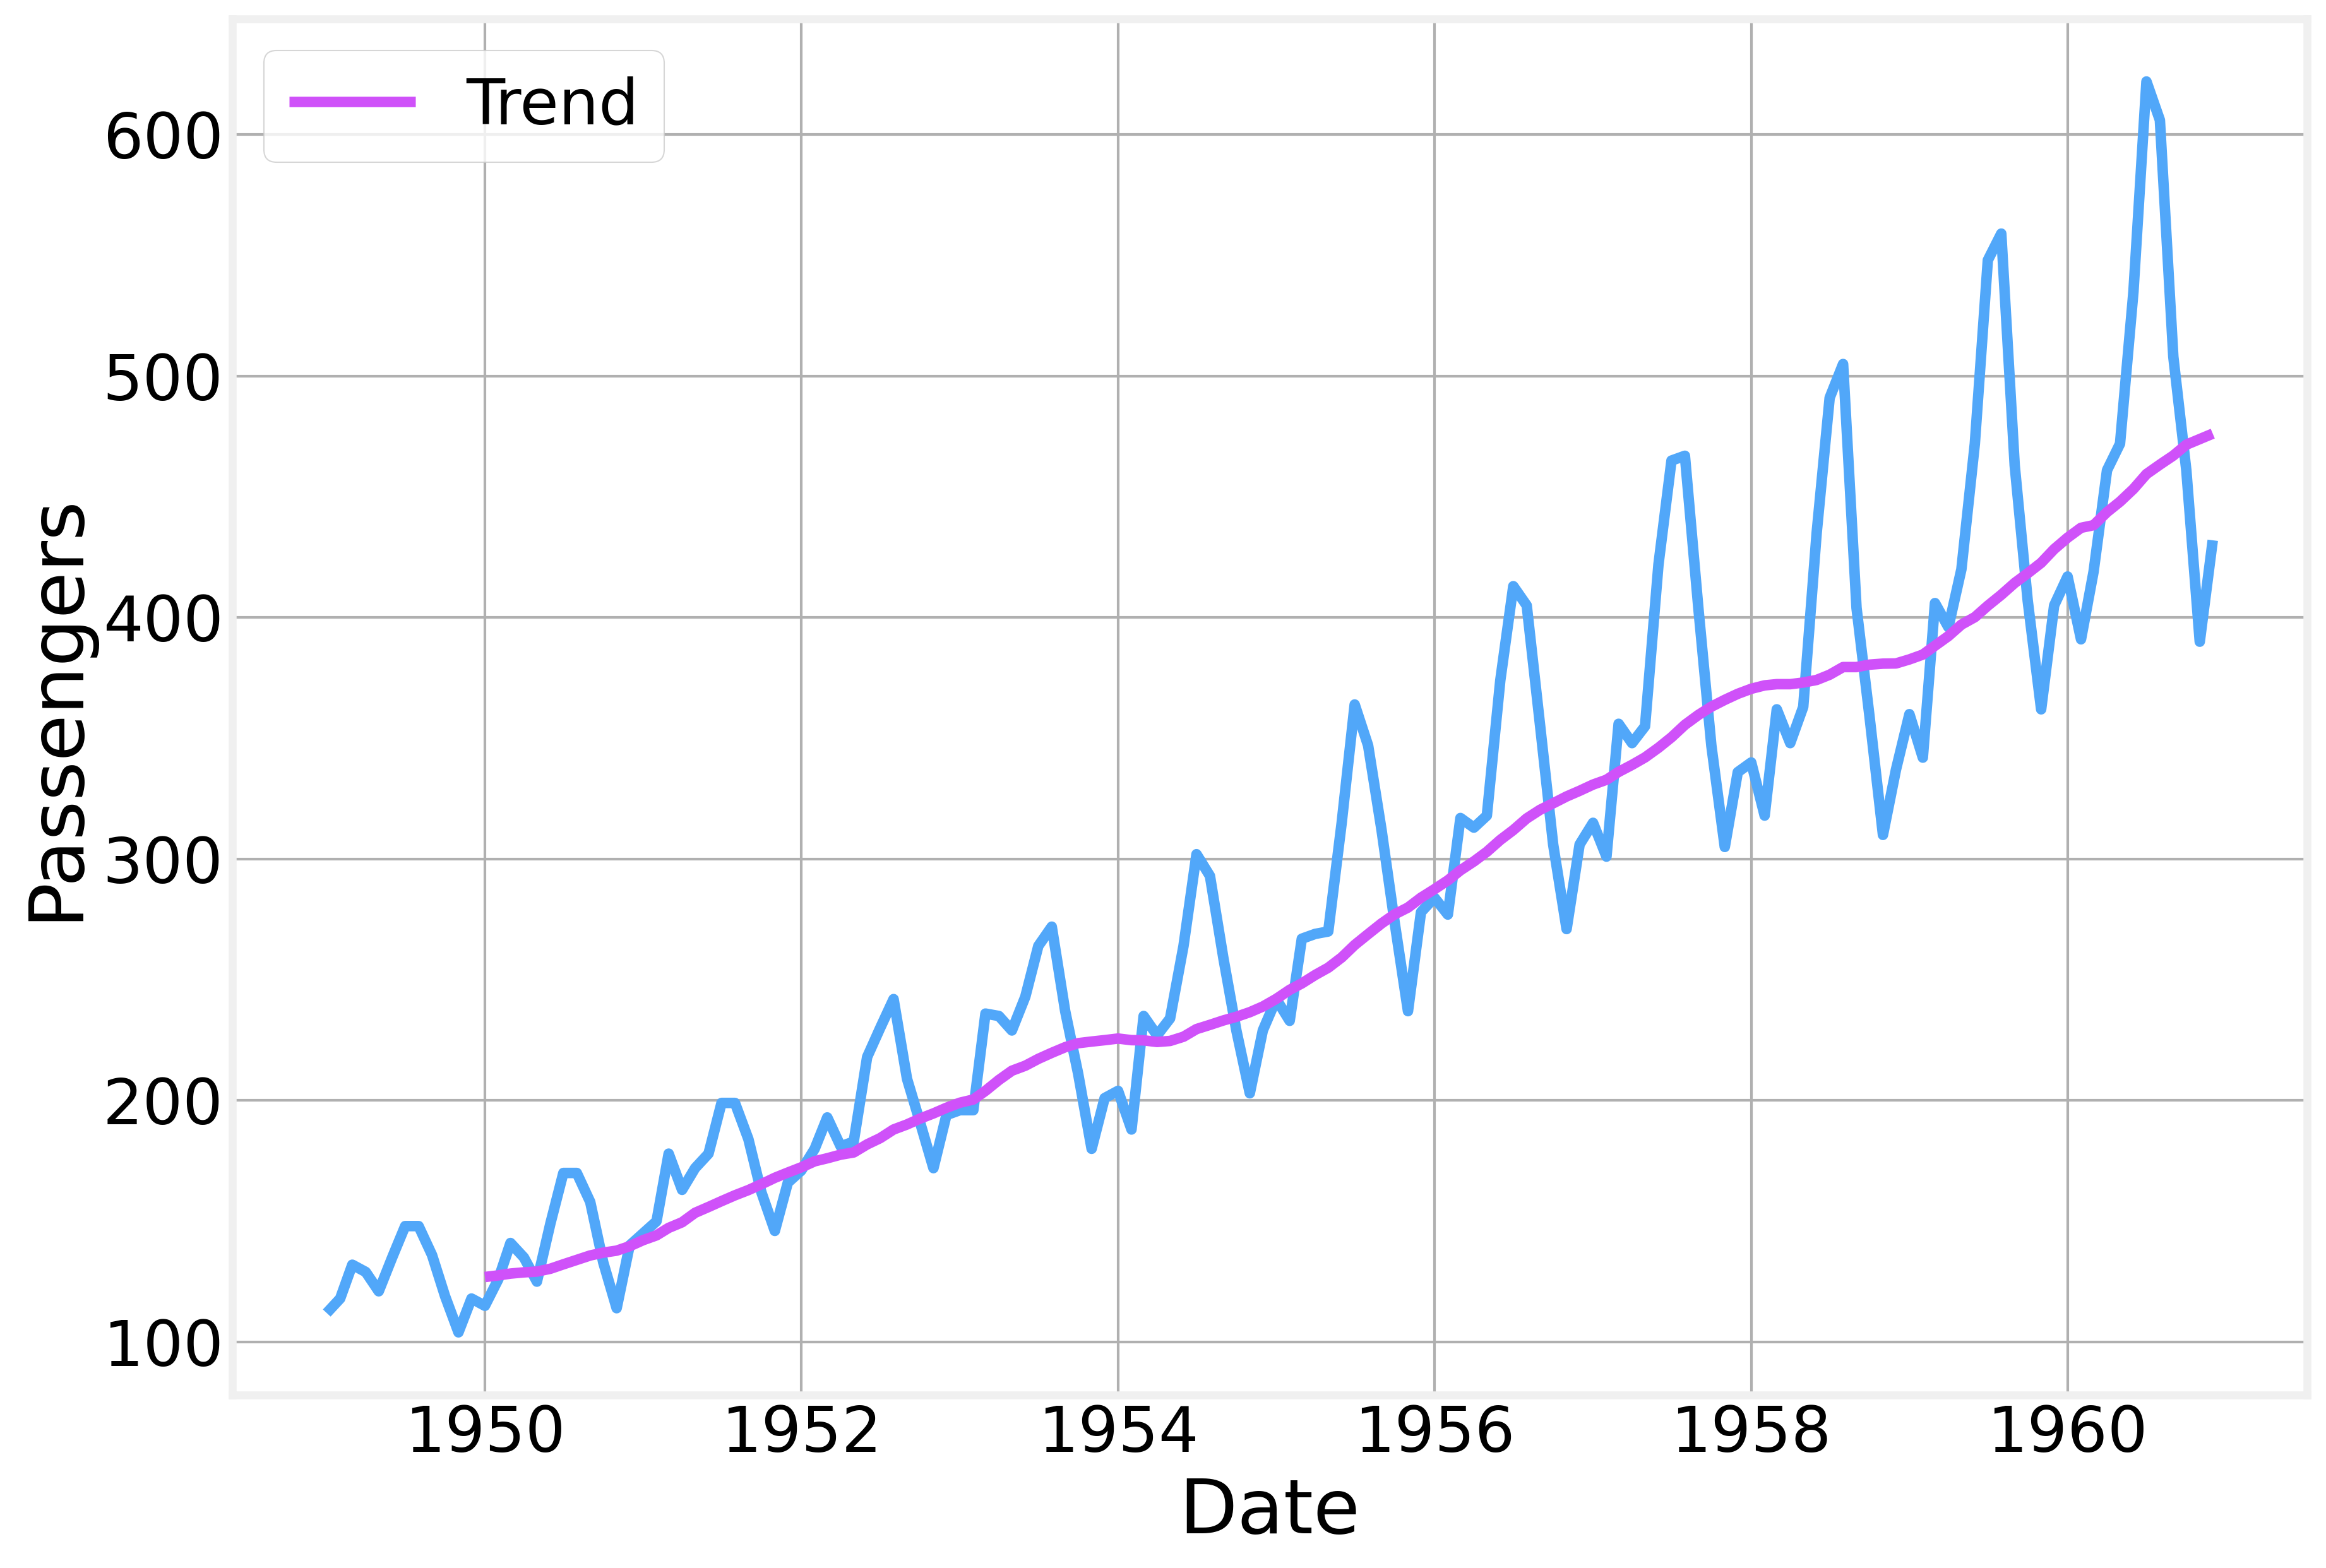

In [7]:
trend = running_average(airline['Passengers'], 12)

fig, ax = plt.subplots(1, 1)
ax.plot(airline.index, airline['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.plot(airline.index[12:], trend, label='Trend')
ax.legend()

Our simple approach seems to have correctly identified the trend in the data. We move on to the next step of detrending the data by dividing by the trend

In [8]:
detrended = airline.iloc[12:].values.flatten()/trend

And the detrended data is now

Text(0, 0.5, 'Detrended value')

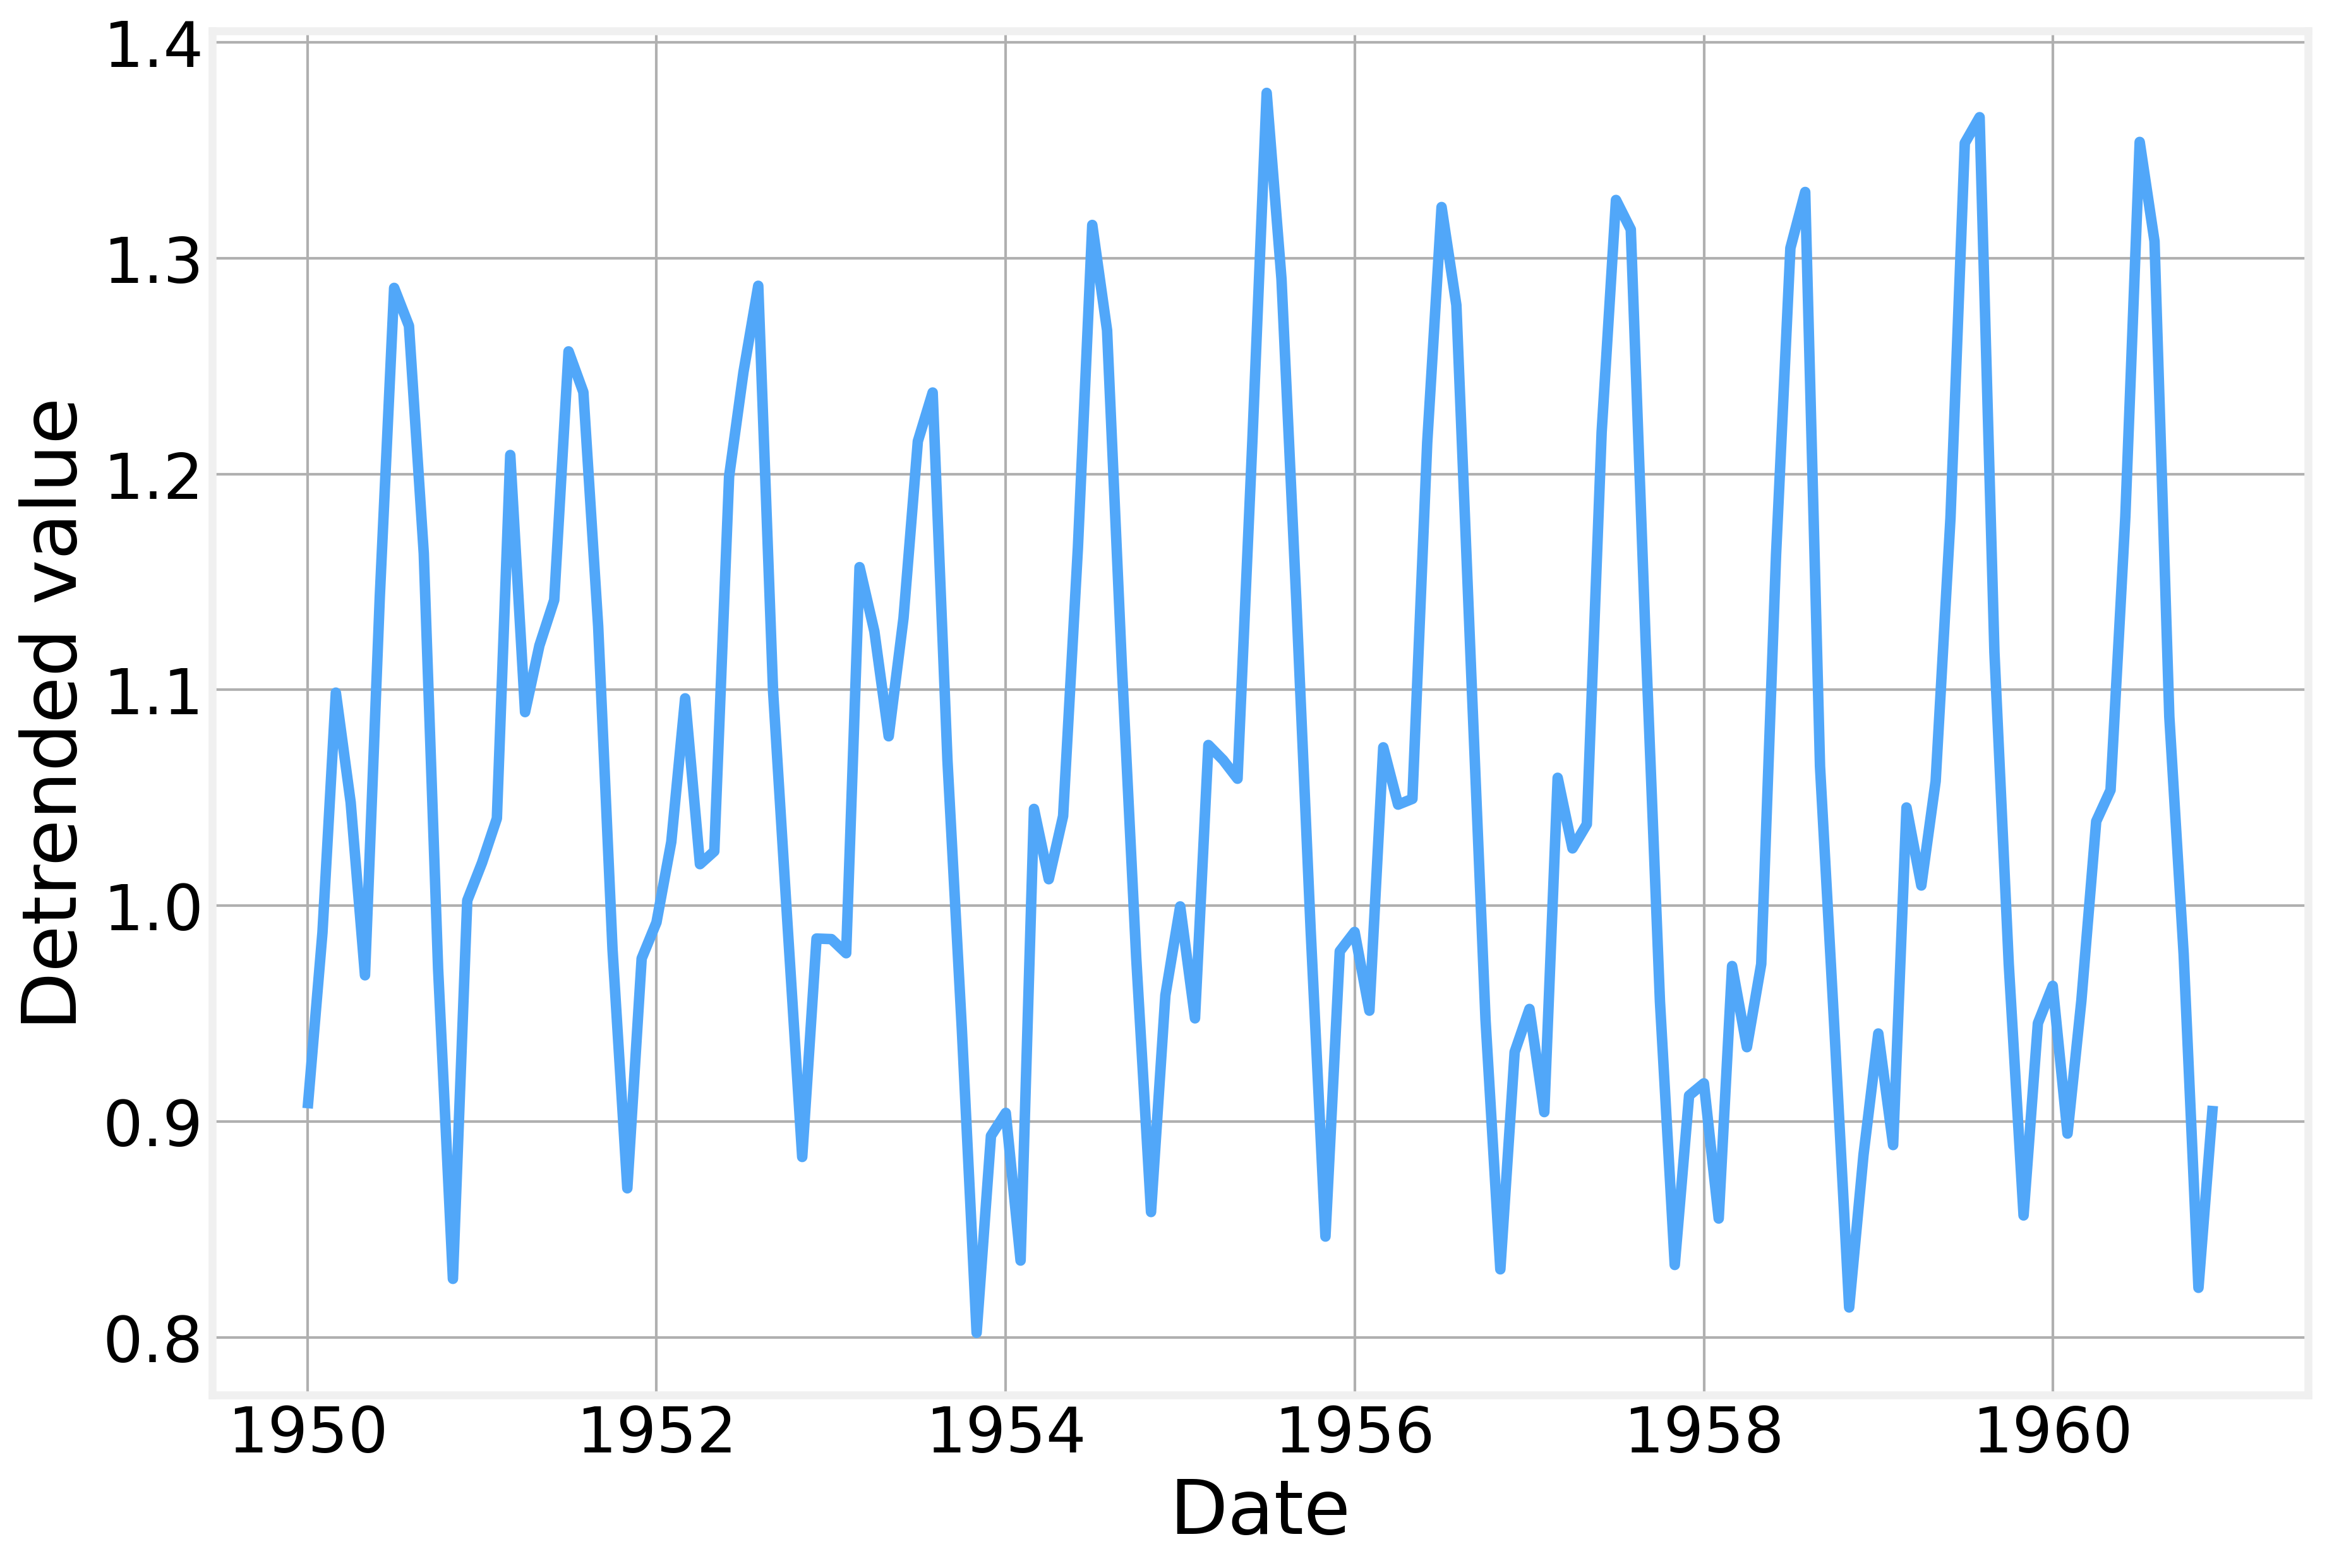

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(airline.index[12:], detrended)
ax.set_xlabel('Date')
ax.set_ylabel('Detrended value')

## Seasonality

There's also a clear seasonal pattern. We identify the period by inspection of the plot. A simple way of making sure that we have the correct pattern is to generate a "seasonal subplots" figure.

In [10]:
def plot_seasons(detrended, order, plot_mean = True):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    N = len(detrended)

    data = np.array([detrended[i::order] for i in range(order)])
    
    means = np.mean(data, axis=1)
    medians = np.median(data, axis=1)
    
    counts = [0]
    counts.extend([len(data[i]) for i in range(order)])
    counts = np.cumsum(counts)

    ticks = (counts[:-1]+counts[1]/2)
    
    for i in range(order):
        values = data[i, :]
        npoints = len(values)

        plt.plot(range(counts[i], counts[i+1]), values, c=colors[0])
        plt.plot(range(counts[i], counts[i+1]), np.ones(npoints)*means[i], c=colors[1])
        plt.plot(range(counts[i], counts[i+1]), np.ones(npoints)*medians[i], c=colors[2])

    plt.legend(['data', 'mean', 'median'])
    plt.xlabel('season')
    plt.ylabel('values')
    plt.xticks(ticks, np.arange(order));
    
    if plot_mean:
        plt.plot(ticks, means, c=colors[3])
    
    return means

Here we simply plot a curve for each of the periods in the season. This is done by simply going through the dataset with a stride equal to the seasonality period

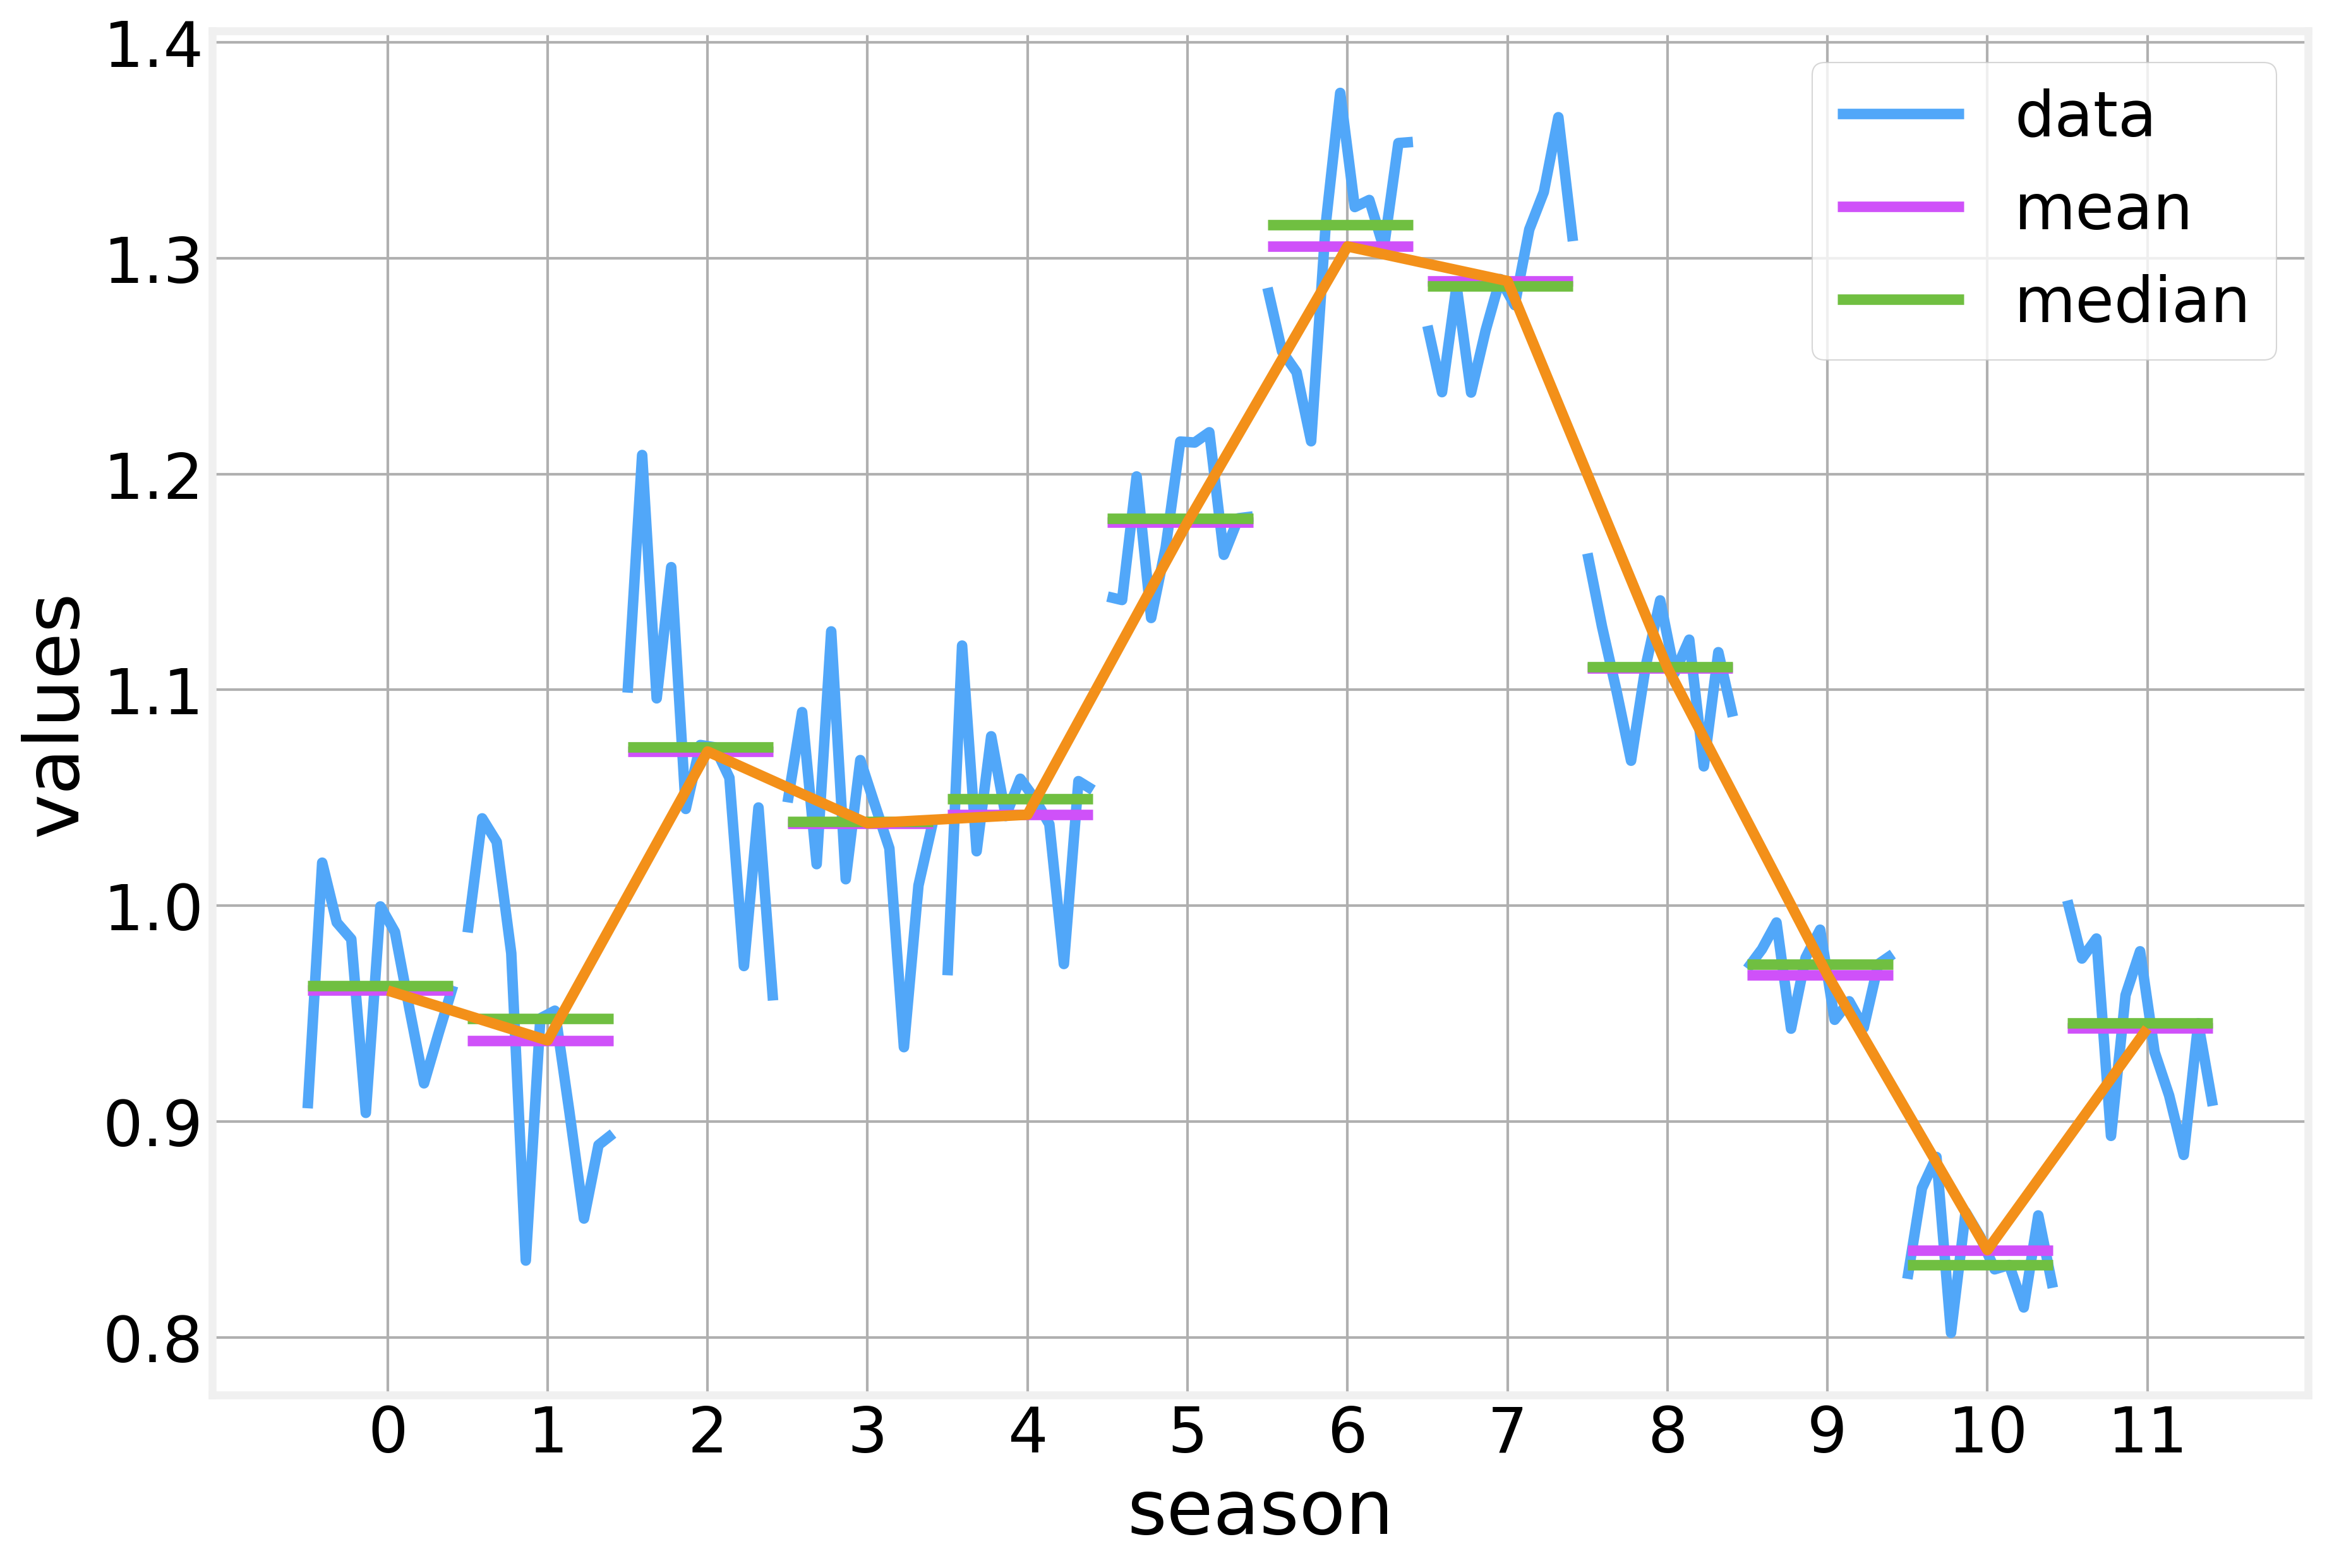

In [11]:
means = plot_seasons(detrended, 12)

This figure also provides us with the archetypal from of the seasonality patttern. WIth this in hand we can now finish the decomposiion of the original data in it's three components

In [12]:
# Multiplicative decomposition
def decomposition(data, order, plot=True):
    values = data.values.flatten()

    trend = running_average(values, order)
    detrended = values[order:]/trend
    
    season = [detrended[i::order].mean() for i in range(order)]
    seasonality = np.array(season*(detrended.shape[0]//order+1))[:detrended.shape[0]]
    
    residuals = values[order:]/(trend*seasonality)

    if plot:
        fig, axs = plt.subplots(4, 1, figsize=(22, 16), sharex=True)
        index = data.index

        axs[0].plot(index, values)
        axs[0].set_title('Original data')
        
        axs[1].plot(index[order:], trend)
        axs[1].set_title('Trend')

        axs[2].plot(index[order:], detrended)
        axs[2].set_title('Seasonality')

        axs[3].plot(index[order:], residuals)
        axs[3].set_title('Residuals')
        
    return values, trend, seasonality, residuals

The seasonal pattern is removed by repeating the average sesonal pattern identified above and dividing it from the detrended data. The result of this division are simply the residuals, a measure of how much our simple decomposition model fails at each point

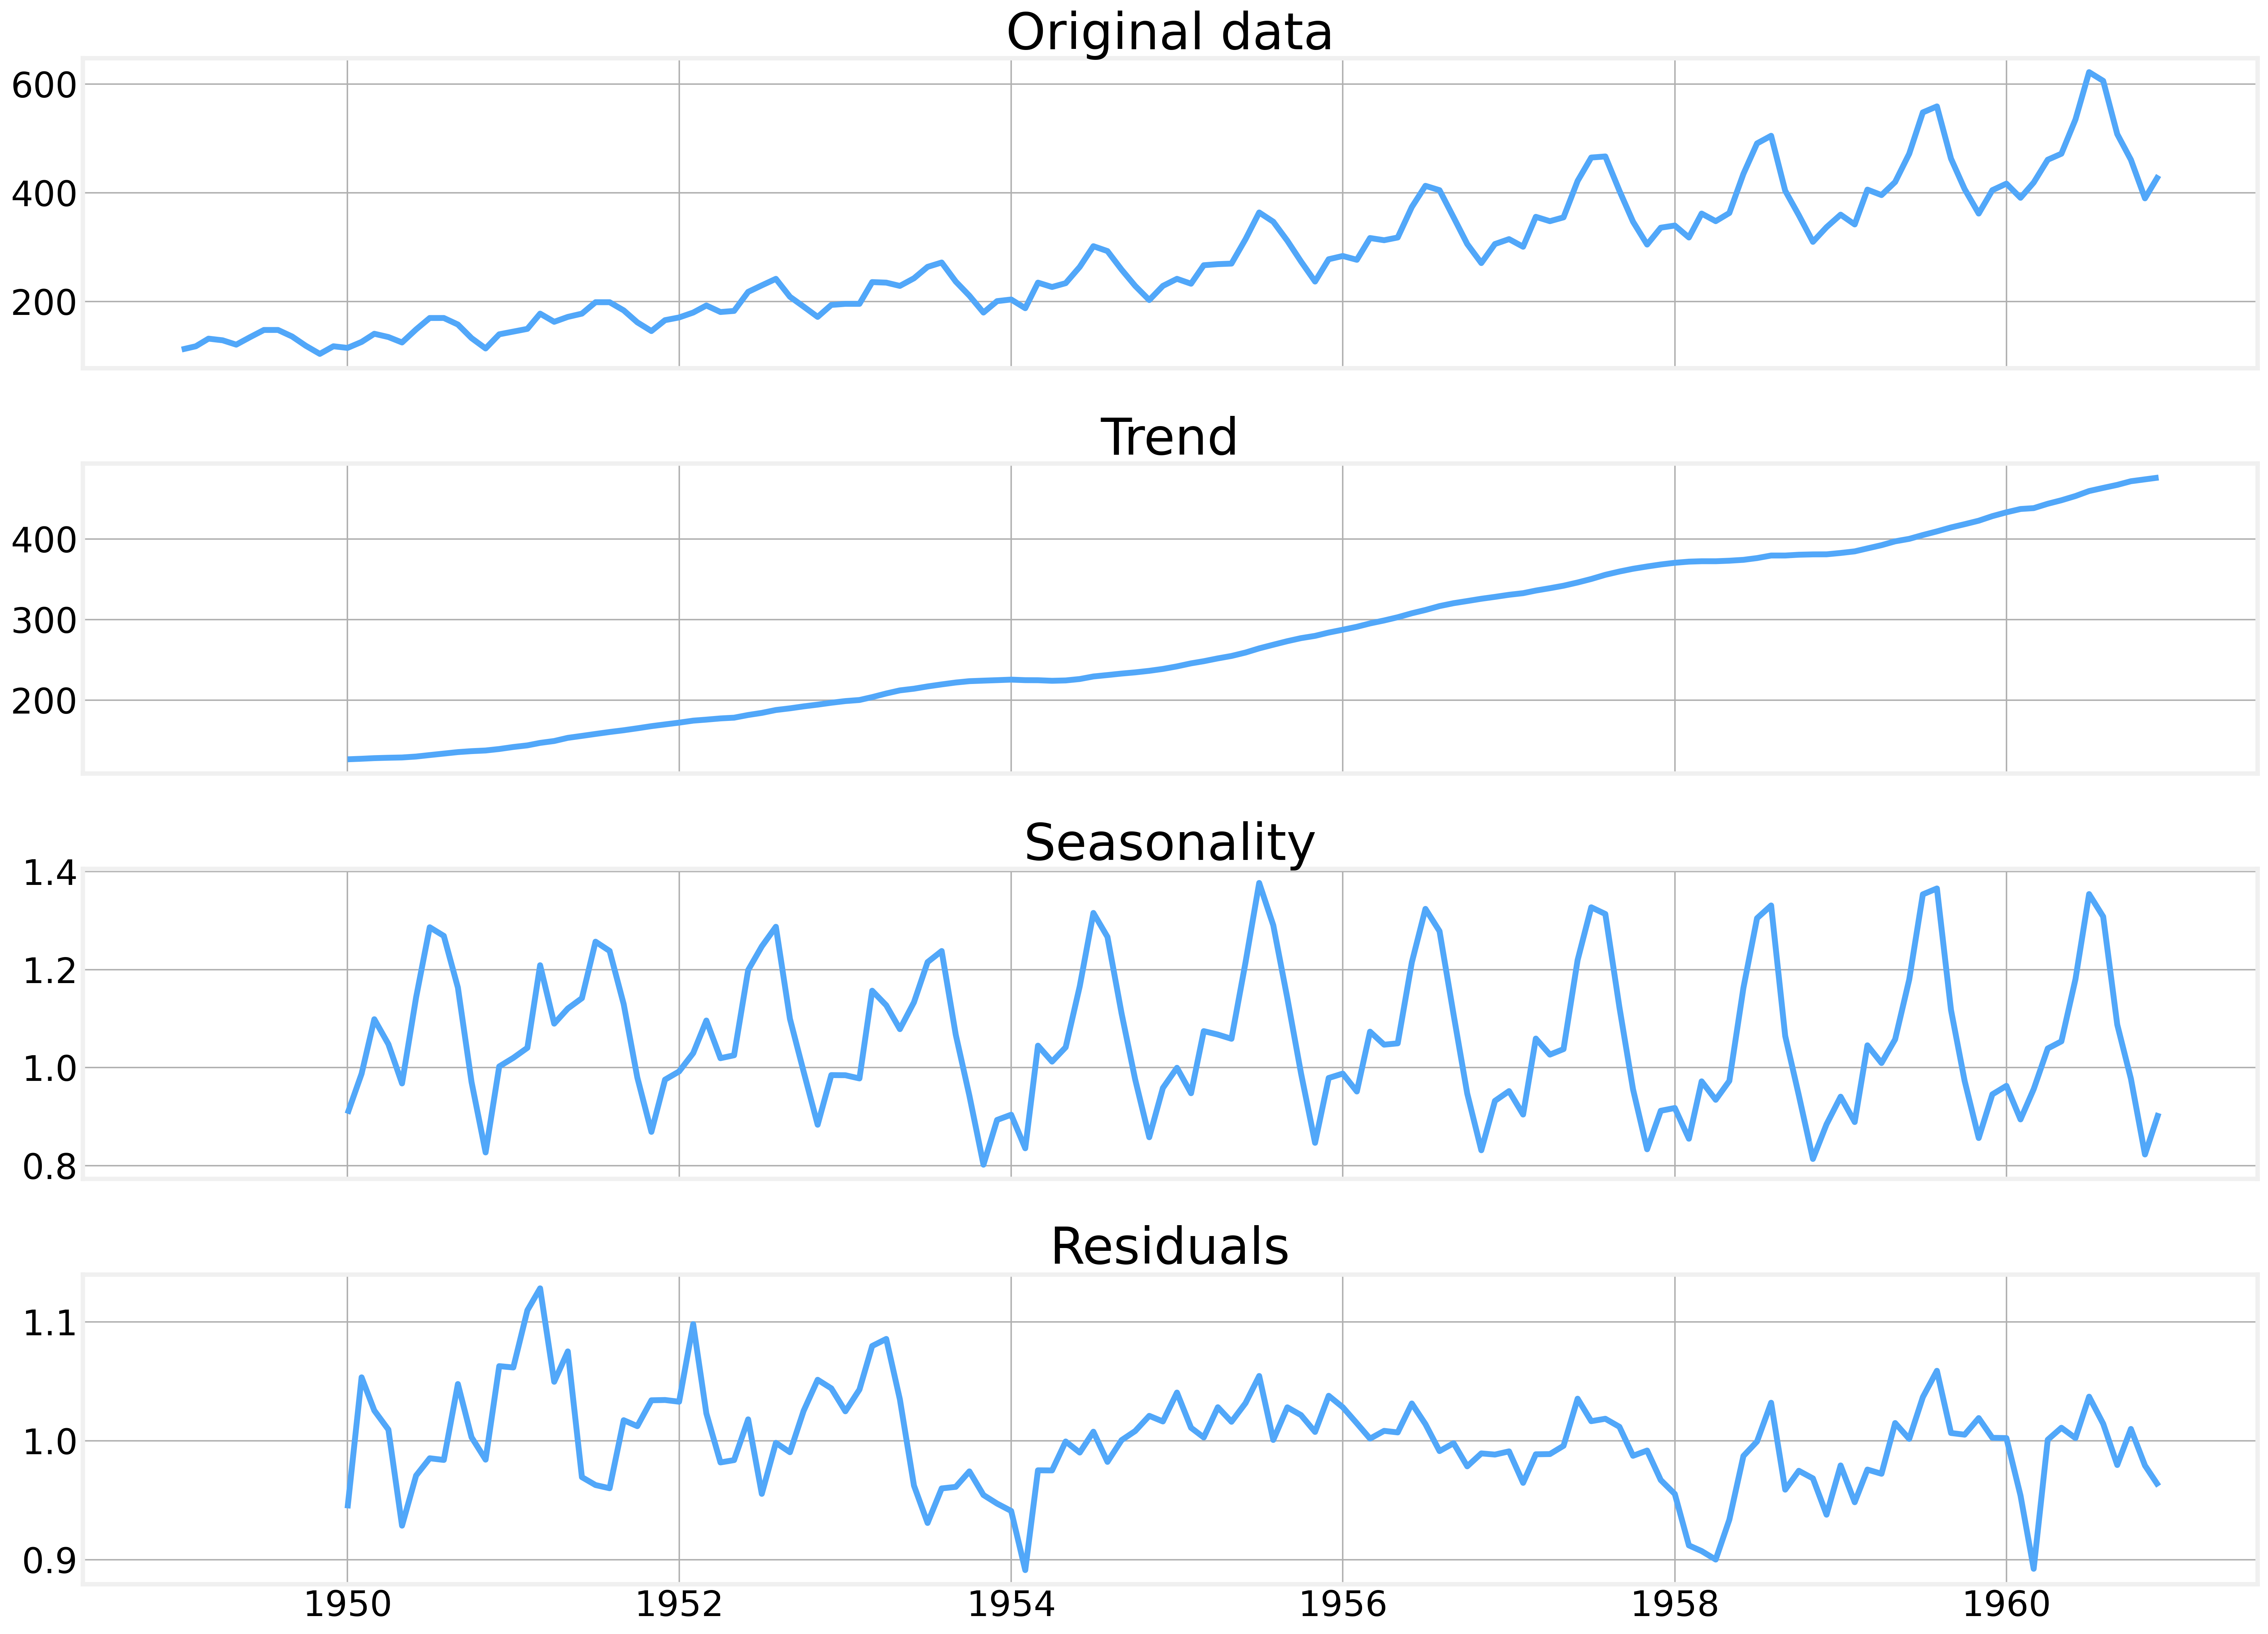

In [13]:
values, trend, seasonality, residuals = decomposition(airline, 12)

Here we used a multiplicative decomposition. The same procedure could have been followed with an additive decomposition with only small changes to the code

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>